In [1]:
%pylab inline

import anacal
import numpy as np
import matplotlib.pylab as plt

import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs
import fitsio
import os

# LSST task to define DC2-like skymap 
from lsst.skymap.discreteSkyMap import (
    DiscreteSkyMapConfig, DiscreteSkyMap,
)
from lsst.pipe.tasks.coaddBase import makeSkyInfo

from xlens.simulator.catalog import (
    CatalogShearTask,
    CatalogShearTaskConfig,
)
from xlens.simulator.sim import (
    MultibandSimConfig, MultibandSimTask
)

# Detection Task: Detect, shape measurement
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipeConfig, 
    AnacalDetectPipe,
)

# Force color measurement Task: 
# flux measurement on the other bands
from xlens.process_pipe.anacal_force import (
    AnacalForcePipe,
    AnacalForcePipeConfig,
)

# Match Task: match to input catalog
from xlens.process_pipe.match import (
    matchPipe,
    matchPipeConfig,
)

from astropy.visualization import ZScaleInterval

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Initialize SkyMap

In [2]:
pixel_scale = 0.2
mag_zero = 30
npix_inner = 4000
npix_pad = 100

In [3]:
config = DiscreteSkyMapConfig()
config.projection = "TAN"

# Define tract center explicitly 
config.raList = [0.0]         # degrees
config.decList = [0.0]        # degrees
config.radiusList = [0.1]     # radius in degrees

config.rotation = 0.0         # tract rotation in degrees

# Patch and tract configuration
config.patchInnerDimensions = [4000, 4000]  # inner size of patch in pixels
config.patchBorder = 100                    # border size in pixels
config.pixelScale = pixel_scale             # arcsec/pixel
config.tractOverlap = 0.0                   # no overlap

# Create the skymap
skymap = DiscreteSkyMap(config)

# Make Image Simultion

In [4]:
band = "i"
tract_id = 0
patch_id = 0

# configuration
config = CatalogShearTaskConfig()
config.kappa_value = 0.0000
config.layout="random"
# z_bounds is the boundaries of redshift bins
# note that there are three options for each redshift bin
# 0: g=-0.02; 1: g=0.02; 2: g=0.00
# for example, number of redshift bins is 4, (z_bounds = [0., 0.5, 1.0,
# 1.5, 2.0]) if mode = 7 which in ternary is "0021" --- meaning that
# the shear is (-0.02, -0.02, 0.00, 0.02) in each bin, respectively.
# In this example I am using 2 redshift bins
config.z_bounds = [-0.01, 1.0, 20.0]
# For distortion mode
config.mode = 2 # g1: (-0.02, 0.0), 
# we can change to mode = 5 for shear g1: (0.02, 0)
cattask = CatalogShearTask(config=config)
truthCatalog = cattask.run(
    tract_info=skymap[tract_id],
    seed=0,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = "lsst"
config.draw_image_noise = True
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[tract_id],
    patch_id=patch_id,
    band="i",
    seed=0,
    truthCatalog=truthCatalog,
)

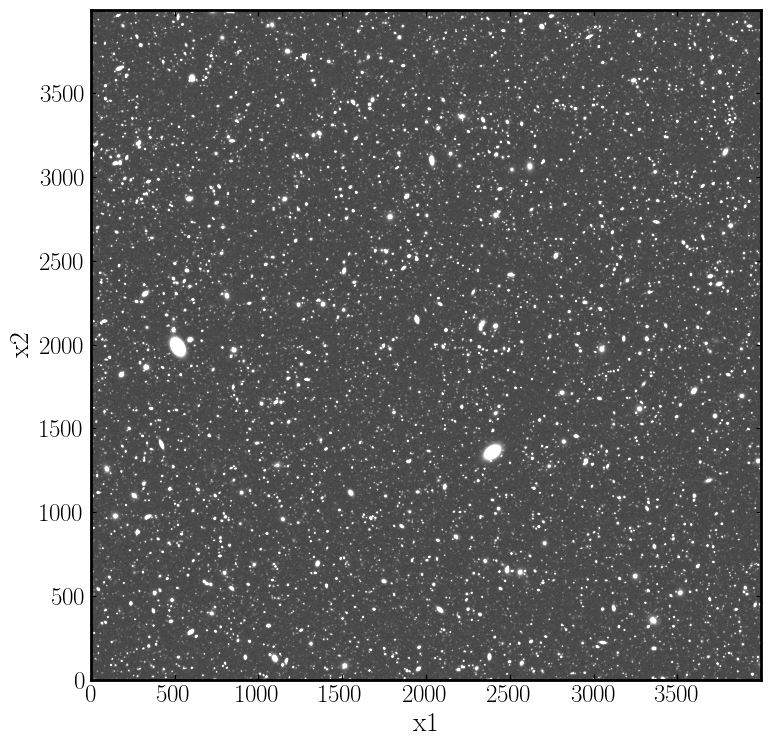

In [5]:
image = outcome.simExposure.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PSF')

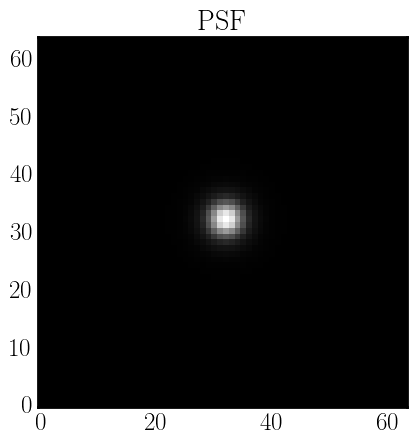

In [6]:
lsst_psf = outcome.simExposure.getPsf()
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(geom.Point2D(2000, 2000)).getArray(), 
        (64, 64)
    ),
    dtype=np.float64,
)
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

# Detect and Measure

In [7]:
# Configuration
config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = False
# Task and preparation
det_task = AnacalDetectPipe(config=config)
seed = (tract_id * 1000 + patch_id) * 5 + 0
data = det_task.anacal.prepare_data(
    exposure=outcome.simExposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
)
# Run catalog
catalog = det_task.anacal.run(**data)

# Shear Estimation
# Code magnitude cut and selection bias correction

#
e1 = catalog["wsel"] * catalog["fpfs_e1"]
de1_dg1 = catalog["dwsel_dg1"] * catalog["fpfs_e1"] + catalog["wsel"] * catalog["fpfs_de1_dg1"]
print(np.sum(e1) / np.sum(de1_dg1))

e2 = catalog["wsel"] * catalog["fpfs_e2"]
de2_dg2 = catalog["dwsel_dg2"] * catalog["fpfs_e2"] + catalog["wsel"] * catalog["fpfs_de2_dg2"]
print(np.sum(e2) / np.sum(de2_dg2))

-0.002712526050321706
-0.0012097846262553


# Force Measurements

In [8]:
# Configuration
config = AnacalForcePipeConfig()
config.do_fpfs = True
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = False
config.fpfs.do_noise_bias_correction = True
config.fpfs.npix = 64
config.fpfs.sigma_arcsec1 = 0.5657
# Task and preparation
force_task = AnacalForcePipe(config=config)
seed = (tract_id * 1000 + patch_id) * 5 + 0
force = force_task.run_one_band(
    exposure=outcome.simExposure,
    detection=catalog,
    band=band,
    seed=seed,
    noise_corr=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
)

# Shear Estimation
# Code magnitude cut and selection bias correction
#
e1 = catalog["wsel"] * force["i_fpfs1_e1"]
de1_dg1 = catalog["dwsel_dg1"] * force["i_fpfs1_e1"] + catalog["wsel"] * force["i_fpfs1_de1_dg1"]
print(np.sum(e1) / np.sum(de1_dg1))

e2 = catalog["wsel"] * force["i_fpfs1_e2"]
de2_dg2 = catalog["dwsel_dg2"] * force["i_fpfs1_e2"] + catalog["wsel"] * force["i_fpfs1_de2_dg2"]
print(np.sum(e2) / np.sum(de2_dg2))

-0.011338079774676369
-0.008818884894909843


In [9]:
force.dtype.names

('i_flux',
 'i_dflux_dg1',
 'i_dflux_dg2',
 'i_fpfs1_e1',
 'i_fpfs1_de1_dg1',
 'i_fpfs1_e2',
 'i_fpfs1_de2_dg2',
 'i_fpfs1_q1',
 'i_fpfs1_dq1_dg1',
 'i_fpfs1_q2',
 'i_fpfs1_dq2_dg2',
 'i_fpfs1_m00',
 'i_fpfs1_dm00_dg1',
 'i_fpfs1_dm00_dg2',
 'i_fpfs1_m20',
 'i_fpfs1_dm20_dg1',
 'i_fpfs1_dm20_dg2',
 'i_fpfs1_m22c',
 'i_fpfs1_dm22c_dg1',
 'i_fpfs1_m22s',
 'i_fpfs1_dm22s_dg2')

In [10]:
config = matchPipeConfig()
config.mag_zero = mag_zero
config.mag_max_truth = 28.0   
match_task = matchPipe(config=config)
match = match_task.run(
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    catalog=catalog,
    dm_catalog=None,
    truth_catalog=truthCatalog,
).catalog
cat_ref = fitsio.read(
    os.path.join(os.environ["CATSIM_DIR"], "OneDegSq.fits")
)

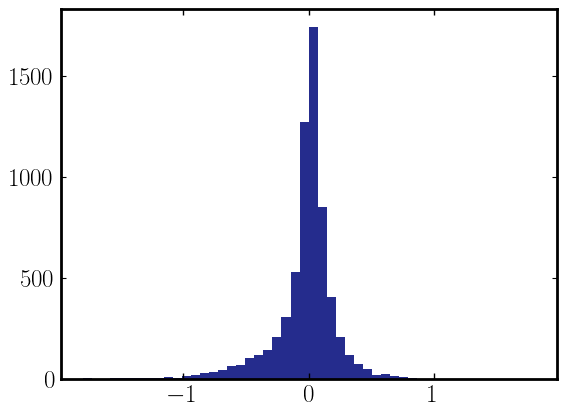

In [11]:
mag_truth = cat_ref[match["truth_index"]]["i_ab"]
mag = mag_zero - 2.5* np.log10(match["flux"])
sel = mag<25
_ = plt.hist(mag[sel] - mag_truth[sel], bins=50, range=(-1.8, 1.8))

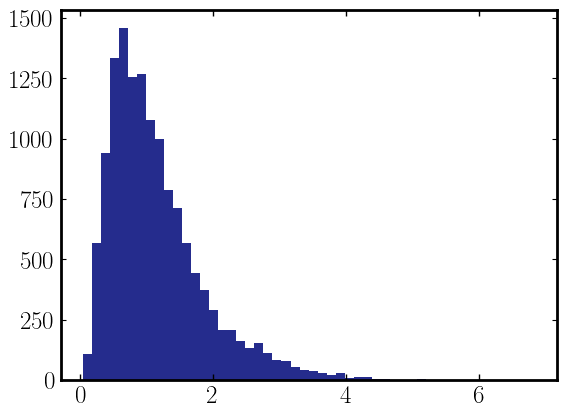

In [12]:
redshift = cat_ref[match["truth_index"]]["redshift"]
_=plt.hist(redshift, bins=50)